# 📜Summary
**Introduction:** Efficient operations in the airline industry hinge on maximizing the number of flights to optimize revenue. However, maintaining a tight schedule poses a significant risk of network delays. A single delayed flight not only impacts its immediate successor but can ripple through subsequent flights, amplifying disruptions across the network. This is why Airlines does it best to improve their On-Time Performance.

**Problem:** How can we maximize the number of flights while mitigating the risk of disruption?

**Hypothesis:** If we are able to know the chances of a flight being delayed, we  can plan our flight schedules better.

**Goal:** Predict the probability of delays for flights.

[kaggle](https://www.kaggle.com/code/fiftythirtyfour/usa-airline-on-time-performance/edit)

# 🌳Editor's Notes
## 🌿Iterate Fast
Always favor to do iteration fast. Work on a sample. Process the data and save it if you only need to do it once.

## 🌿Always use "g" when exploring Data.
Explore data using variable g and make sure you don't go out of the cell. Don't leave random variables lying around.


✅Converted all date time to utc time  
✅Replaced airport placeholder codes to correct iata codes  
✅Calculated Scheduled and Actual Block times  
📌elapsed time and all other times are not minutes duration. It means something else.  

# 🤓Data Science

In [1]:
! pip install timezonefinder

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import pytz
from timezonefinder import TimezoneFinder

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 200
pd.options.display.max_rows = 400

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.0 MB/s eta 0:00:00


In [2]:
### Load
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv') ## Raw
# df = pd.read_parquet('df.parquet', engine='pyarrow') ## Preprocessed

airl = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
airp = pd.read_csv('/kaggle/input/airport-timezone/airports_timezone.csv')
timezone = dict(zip(airp['iata_code'], airp['timezone'].apply(lambda x: pytz.timezone(x)) ))

In [3]:
## Get Timezones
def getTimezone(latlon):
    lat, lon = latlon
    tf = TimezoneFinder()
    return tf.timezone_at(lat=lat, lng=lon)

def processAirports(path):
    a = pd.read_csv(path)
    a.columns = a.columns.str.lower()

    a.loc[a['iata_code'] == "UST", ["latitude", "longitude"]] = (29.9581, -81.3416)
    a.loc[a['iata_code'] == "ECP", ["latitude", "longitude"]] = (30.3583, -85.7956)
    a.loc[a['iata_code'] == "PBG", ["latitude", "longitude"]] = (44.6509, -73.4663)

    a['timezone'] = a[['latitude', 'longitude']].apply(getTimezone, axis=1)
    a.to_csv('airports.csv')

## getting placeholder to iata
def getFreqAirport(a):
    plc = [x for x in a.unique() if len(x) > 3]
    chk = pd.Series([x for x in a if len(x) == 3])
    return (plc[0] if plc else None, chk.mode().iloc[0] if not chk.mode().empty else None)

def getIata(b):
    ## Get the most frequent airport based on the airline, flight number, and scheduled_departure time.
    ## It is rare that airlines would use a different flight number for the same origin-destination and departure time.
    b = b.groupby(['airline', 'flight_number', 'scheduled_departure'])['origin_airport'].apply(getFreqAirport).apply(pd.Series)
    b = b.reset_index().dropna()
    b.columns = ['airline', 'flight_number', 'scheduled_departure', 'placeholder', 'iata']
    b = b.groupby(['placeholder']).apply(lambda x: x['iata'].mode().iloc[0]).reset_index()
    b.columns = ['placeholder', 'iata']
    return dict(zip(b['placeholder'], b['iata']))

def convert_int_to_time(integer_time):
    if integer_time == 2400:
        hours = 0
        minutes = 0
    else:
        hours = integer_time // 100
        minutes = integer_time % 100

    return dt.time(hours, minutes)

### Cleaning
def cleanData(a):
    a.columns = a.columns.str.lower()
    a['origin_airport'] = a['origin_airport'].astype(str)
    a['destination_airport'] = a['destination_airport'].astype(str)
    a['scheduled_departure'] = [convert_int_to_time(x) for x in a['scheduled_departure']]
    a['scheduled_arrival'] = [convert_int_to_time(x) for x in a['scheduled_arrival']]
    a['departure_time'] = [convert_int_to_time(x) for x in a['departure_time'].fillna(0).astype(int)]
    a['arrival_time'] = [convert_int_to_time(x) for x in a['arrival_time'].fillna(0).astype(int)]
    
    a['std_ls_date'] = pd.to_datetime(a[['year', 'month', 'day']])

    a['std_ls_date_time'] = pd.to_datetime(a['std_ls_date'].astype(str) + ' ' + a['scheduled_departure'].astype(str))
    a['sta_ls_date_time'] = a['std_ls_date_time'] + pd.to_timedelta(a['scheduled_time'], unit='m', errors='coerce')
    ## Local time is based on origin airport to be consistent in converting to UTC.
    a['atd_ls_date_time'] = a['std_ls_date_time'] + pd.to_timedelta(a['departure_delay'], unit='m', errors='coerce')
    a['ata_ls_date_time'] = a['sta_ls_date_time'] + pd.to_timedelta(a['arrival_delay'], unit='m', errors='coerce')

    a['anchor'] = a['airline'] + [str(x).zfill(5) for x in a['flight_number']] + '|' + a['std_ls_date'].dt.strftime('%Y-%m-%d') + '|' + df['origin_airport'].astype(str)
    a['otp_dly15'] = np.where(a['departure_delay'] > 15, 0.0, 1.0)
    return a

def mapData(a, tz, ia):
    ### Replace placeholder for October with actual airport iata codes.
    a['origin_airport'] = a['origin_airport'].replace(ia)
    a['destination_airport'] = a['destination_airport'].replace(ia)
    a['orig_timezone'] = a['origin_airport'].map(tz)    
    a['dest_timezone'] = a['destination_airport'].map(tz)    
    return a

def convertUTC(a):
    ### Convert local time of departure and arrival to UTC time based on origin timezone.
    a['std_z_date_time'] = a.apply(
        lambda row: row['std_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    a['sta_z_date_time'] = a.apply(
        lambda row: row['sta_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    a['atd_z_date_time'] = a.apply(
        lambda row: row['atd_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    a['ata_z_date_time'] = a.apply(
        lambda row: row['ata_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    return a

In [4]:
## Execute

# processAirports('/kaggle/input/flight-delays/airports.csv', index=False) ## Process this once, then save.
df = cleanData(df)

iatacodes = getIata(df) ## Detour. Get Iata codes for missing stations on October.
iatacodes['10577'] = 'BGM' ## Manually added these flights because they are new for October.
iatacodes['10666'] = 'BLI'

df = mapData(df, timezone, iatacodes)
df = convertUTC(df)
df.drop(['orig_timezone', 'dest_timezone'], axis=1, inplace=True) ## Drop these before to_parquet.

In [5]:
### Organize
dly = [x for x in df.columns if 'delay' in x]
num = [x for x in df.columns if df.dtypes[x] in ('float', 'int64')]
cat = [x for x in df.columns if df.dtypes[x] == "object"]
target = 'otp_dly15'
num.remove(target)

### Split
train = df.query('airline not in ("AA", "US", "OO")')
test = df.query('airline == "OO"')

# 🤓Data Science

In [6]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

otp_dly15              1.000000
air_system_delay       0.145477
cancelled              0.051332
month                  0.034802
flight_number          0.011029
day_of_week            0.009079
day                    0.005494
taxi_in               -0.008328
security_delay        -0.009971
air_time              -0.020627
diverted              -0.021080
distance              -0.023698
scheduled_time        -0.025311
elapsed_time          -0.027939
taxi_out              -0.063010
weather_delay         -0.064881
wheels_on             -0.118969
airline_delay         -0.181280
wheels_off            -0.220746
late_aircraft_delay   -0.273000
arrival_delay         -0.626414
departure_delay       -0.659777
year                        NaN
Name: otp_dly15, dtype: float64

## Merger of American and US Airways
There was a Merger of American Airlines and US Airways in June 2015. Southwest, Delta and American Airlines have the biggest volume of flights in 2015.

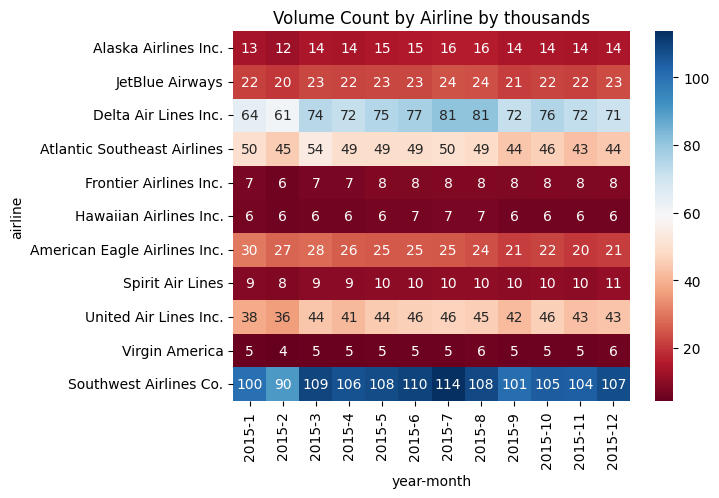

In [7]:
g = train.pivot_table('flight_number', index='airline'
              , columns=['year', 'month']
              , aggfunc='count') / 1000
g.index = g.index.map(airl.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, cmap='RdBu', annot=True, fmt='.0f')

plt.title("Volume Count by Airline by thousands");

## Airline Departure On-Time Performance.
Lower volume flights like Hawaiian, Virgin and Alaska Airlines are almost always on time. Delta and American airlines are also on time taking into consideration that they have more flights in 2015.

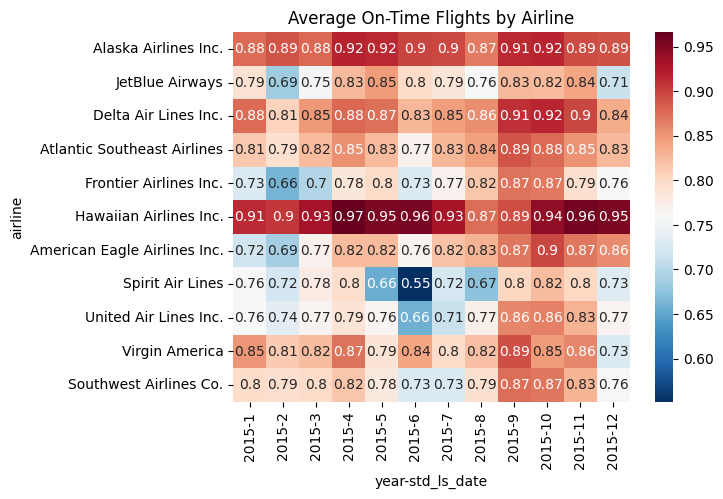

In [8]:
g = train.query('cancelled == 0 and diverted == 0')
g = g.pivot_table(target, index='airline'
             , columns=['year', g['std_ls_date'].dt.month]
             , aggfunc='mean')
g.index = g.index.map(airl.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, annot=True, cmap='RdBu_r')
plt.title('Average On-Time Flights by Airline');

## Flight Plan

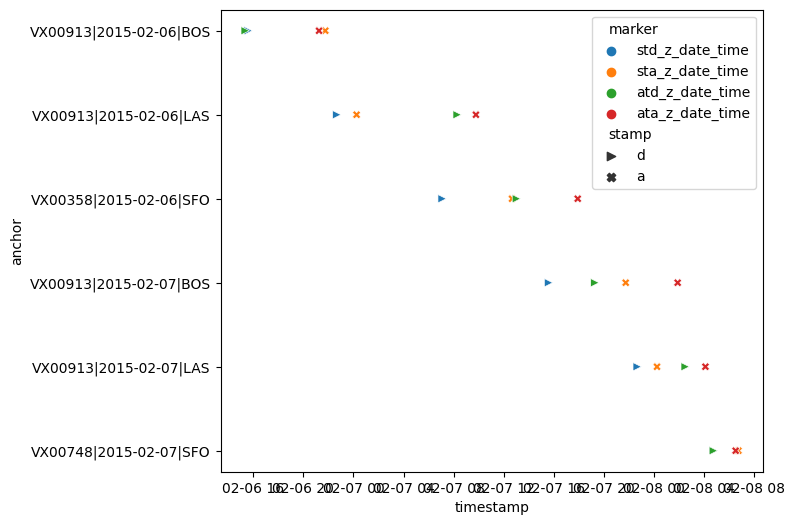

In [9]:
vx = train.query('airline=="VX"')
g = vx.query('tail_number == "N361VA"')
g = g.query('"2015-02-06" <= std_ls_date <= "2015-02-07"')
g = g.loc[~g['departure_delay'].isnull()]
g = g[[
    'anchor'
    ,'std_z_date_time'
   , 'sta_z_date_time'    
   , 'atd_z_date_time'
   , 'ata_z_date_time'
      ]]

g = pd.melt(g, id_vars='anchor', var_name='marker', value_name='timestamp')
g['stamp'] = g['marker'].str[2:3]
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot (g, x='timestamp', y='anchor'
                 , hue='marker'
                 , style='stamp'
                 , markers={'d': '>', 'a': 'X'}
                 , ax=ax);

# 🤖Machine

## Pipeline

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [11]:
class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att):
        self.att = att
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.att]

In [12]:
# num_pp = Pipeline([
#     ('dataselect', DataSelect([
#         'arrival_delay'
#         , 'air_system_delay'
#         , 'security_delay'
#         , 'airline_delay'
#         , 'late_aircraft_delay'
#         , 'weather_delay'
#     ]))
#     , ('impute', SimpleImputer(strategy='mean'))
#     , ('scaler', StandardScaler())
# ])

# cat_pp = Pipeline([
#     ('dataselect', DataSelect([
#         'airline'
#         , 'diverted', 'cancelled'
#     ]))
#     , ('encoder', OneHotEncoder(sparse_output=False))
# ])

# pipe = FeatureUnion([
#     ('num_pp', num_pp)
#     , ('cat_pp', cat_pp)
# ])

# pipe.fit(train)
# train_pp = pipe.transform(train)
# test_pp = pipe.transform(test)

## Model

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [14]:
# gnb = GaussianNB()
# gnb.fit(train_pp, train[target])

In [15]:
# cross_val_score(gnb, train_pp, train[target]).mean()

In [16]:
# cross_val_score(gnb, test_pp, test[target]).mean()

In [17]:
# machines = [
#     GaussianNB()
# #     , SVC()
# #     , RandomForestClassifier(random_state=0)
# ]

# def getBaseline(lst, X, y):
#     rt = []
#     for m in machines:
#         m.fit(X, y)
#         rt.append({
#             'model': m
#             , 'base': cross_val_score(m, X, y).mean()
#         })
#     return pd.DataFrame(rt)

# models = getBaseline(machines, train_pp,  train[target])
# models

In [18]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from sklearn.model_selection import cross_val_predict

# def getScores(m, X, y):
#     prediction = cross_val_predict(m, X, y)
#     return {
#         'accuracy': accuracy_score(y, prediction)
#         , 'precision': precision_score(y, prediction)
#         , 'recall': recall_score(y, prediction)
#         , 'f1_score': f1_score(y, prediction)
#         , 'roc_auc_score': roc_auc_score(y, prediction)
#     }

# scores = pd.DataFrame({
#     'tr_base': getScores(gnb, train_pp, train[target])
# #     , 'tr_tune': getScores(model_tune, train_pre, train[target])
#     , 'te_base': getScores(model, test_pre, test[target])
# #     , 'te_tune': getScores(model_tune, test_pre, test[target])
# })

# # scores['tr_diff'] = (scores['tr_tune'] / scores['tr_base'] -1) * 100
# # scores['te_diff'] = (scores['te_tune'] / scores['te_base'] -1) * 100
# # scores.drop(['tr_base', 'te_base'], axis=1, inplace=True)
# scores